# **Evaluate the saved model**

This notebook is showing that the way to load the trained model and see the results on test data.


##1. Load the dataset

In [0]:
from google.colab import files

uploaded = files.upload()

!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

!kaggle datasets download -d vikramtiwari/pix2pix-dataset
!unzip \*.zip  && rm *.zip
!apt-get install tree

Streaming output truncated to the last 5000 lines.
  inflating: edges2shoes/edges2shoes/train/8216_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8217_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8218_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8219_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/821_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8220_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8221_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8222_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8223_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8224_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8225_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8226_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8227_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8228_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8229_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/822_AB.jpg  
  inflating: edges2shoes/edges2shoes/tr

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os,shutil
import pandas as pd
import torch
import numpy as np
from torch import nn
from torchsummary import summary
import torchvision
from torchvision import datasets
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
class get_dataset(torch.utils.data.Dataset):
  def __init__(self,name='edges2shoes',type_='train',transform=None):
    self.dir_=name+'/'+name+'/'+type_
    self.img_list=sorted(os.listdir(self.dir_))
    self.transform=transform
  def __len__(self):
    return len(self.img_list)
  def __getitem__(self,idx):
    both=plt.imread(self.dir_+'/'+self.img_list[idx]).astype('uint8')
    x=both[:,:both.shape[1]//2,:]
    y=both[:,both.shape[1]//2:,:]
    x,y=self.transform(Image.fromarray(x)),self.transform(Image.fromarray(y))
    return x,y   

img_size=128
batch_size=32

my_transform=transforms.Compose([transforms.Resize((img_size,img_size)),transforms.ToTensor()])
dataset_edges2shoes=get_dataset(name='edges2shoes',type_='val',transform=my_transform)

dataloader=torch.utils.data.DataLoader(dataset_edges2shoes,batch_size=batch_size,shuffle=True,drop_last=True)

##2. Create the same Generator Class

In [0]:
# for 128,128 size
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()

    self.enc_layer1=conv_block(4,8)
    self.enc_layer2=conv_block(8,16)
    self.enc_layer3=conv_block(16,32)
    self.enc_layer4=conv_block(32,64)
    self.enc_layer5=conv_block(64,128)
    self.bottleneck=conv_block(128,256,kernel_size=4,stride=1,padding=0)

    self.dec_layer1=transconv_block(256,128,kernel_size=4,stride=1,padding=0)
    self.dec_layer2=transconv_block(256,64)
    self.dec_layer3=transconv_block(128,32)
    self.dec_layer4=transconv_block(64,16)
    self.dec_layer5=transconv_block(32,8)
    self.dec_layer6=transconv_block(16,3)
    self.dec_layer7=nn.ConvTranspose2d(6,3,kernel_size=1,stride=1,padding=0)

  def forward(self,x,z):
    z=z.view(-1,1,128,128)
    x=x.view(-1,3,128,128)
    x_noisy=torch.cat([z,x],1)
    enc1=self.enc_layer1(x_noisy)
    enc2=self.enc_layer2(enc1)
    enc3=self.enc_layer3(enc2)
    enc4=self.enc_layer4(enc3)
    enc5=self.enc_layer5(enc4)
    latent=self.bottleneck(enc5)
    dec1=torch.cat([self.dec_layer1(latent),enc5],1)
    dec2=torch.cat([self.dec_layer2(dec1),enc4],1)
    dec3=torch.cat([self.dec_layer3(dec2),enc3],1)
    dec4=torch.cat([self.dec_layer4(dec3),enc2],1)
    dec5=torch.cat([self.dec_layer5(dec4),enc1],1)
    dec6=torch.cat([self.dec_layer6(dec5),x],1)
    output=self.dec_layer7(dec6)

    return output

class conv_block(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=4,stride=2,padding=1):
    super(conv_block,self).__init__()
    self.conv_block=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(out_channels)
    )  
  def forward(self,x):
    return self.conv_block(x)

class transconv_block(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=4,stride=2,padding=1):
    super(transconv_block,self).__init__()
    self.transconv_block=nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels)
    )
  def forward(self,x):
    return self.transconv_block(x)

##3. Load the Generator weights saved previously ...

In [0]:
G=Generator()
filepath='gdrive/My Drive/pix2pixmodel/G.pth'

G.load_state_dict(torch.load(filepath,map_location=torch.device('cpu')))
G.eval()

Generator(
  (enc_layer1): conv_block(
    (conv_block): Sequential(
      (0): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (enc_layer2): conv_block(
    (conv_block): Sequential(
      (0): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (enc_layer3): conv_block(
    (conv_block): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (enc_layer4): conv_block(
    (conv_block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negati

##4. Evaluation -on test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


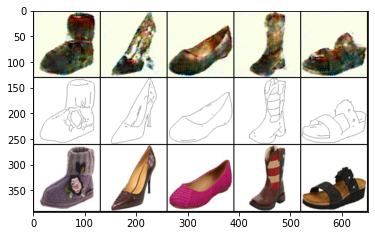

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


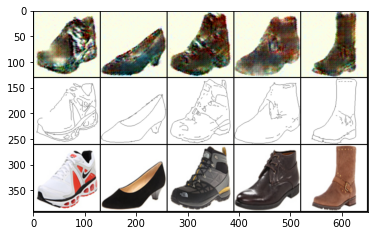

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


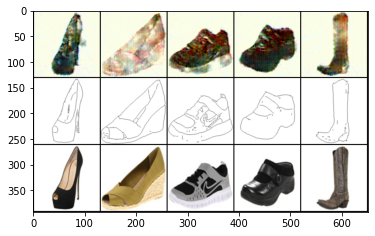

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


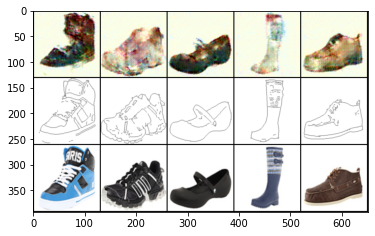

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


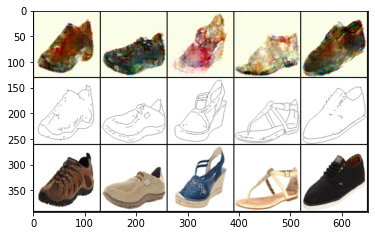

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


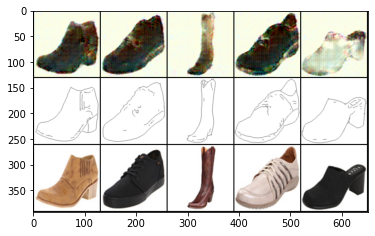

In [0]:
for x,y in dataloader:
  z=torch.randn((batch_size,1,128,128)).to(device)
  generated_imgs=G(x[:5],z[:5])
  real_imgs=x[:5]
  imgs=torch.cat([generated_imgs,real_imgs,y[:5]],0).data.cpu()
  grid=make_grid(imgs,nrow=5).permute(1,2,0).numpy()
  plt.imshow(grid)
  plt.show()